In [1]:
import numpy as np
import numpy.ma as ma

from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.nddata import bitmask
from astropy.nddata.bitmask import BitFlagNameMap
import math

from scipy.ndimage import gaussian_filter1d

In [2]:
SGA_color_data = Table.read('SGA_Color_Params.fits')

In [3]:
# Path to images in NERSC
f1 = math.trunc(SGA_color_data['RA'][3])
f2 = math.trunc((1000*SGA_color_data['RA'][3]))
f3 = math.trunc((100000*SGA_color_data['RA'][3]))
f4 = 'm' if SGA_color_data['DEC'][3] < 0 else 'p'
f5 = abs(math.trunc((100000*SGA_color_data['DEC'][3])))
path = '/pscratch/sd/b/barnerg/SGA2024/cutouts/{:03d}/{:06d}/{:08d}{}{:07d}.fits'.format(f1,f2,f3,f4,f5)
fits_file = fits.open(path)
image = fits_file[0].data
bit_mask = fits_file[1].data

In [4]:
image.shape

(3, 303, 303)

In [5]:
bit_mask.shape

(303, 303)

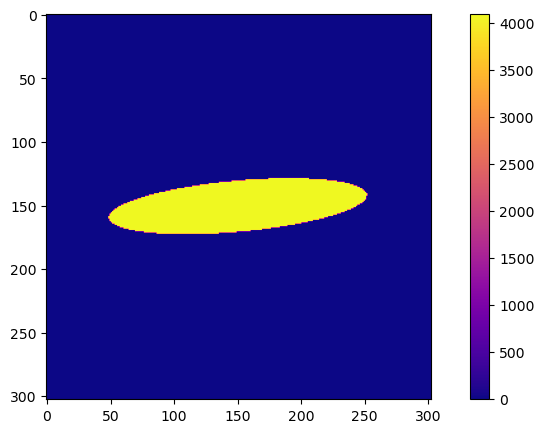

In [6]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(bit_mask, cmap='plasma')
plt.colorbar()

In [7]:
# Reshape the data
if image.shape[0] == 3:
    image_data = np.transpose(image, (1, 2, 0))
image_data.shape

(303, 303, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


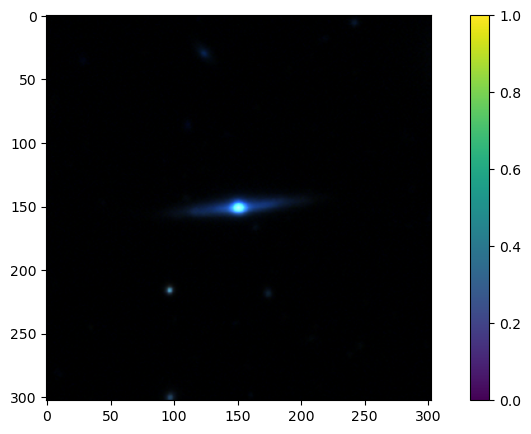

In [8]:
# Showing image 
plt.rcParams["figure.figsize"] = (10, 5)
plt.imshow(image_data)
plt.colorbar()

In [9]:
fits_file.close()

In [10]:
# Bits in the dict
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # SGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
    SATUR_I    = 0x4000,
    ALLMASK_I  = 0x8000,
    SUB_BLOB   = 0x10000,
)

In [11]:
# Generate bitmask to apply to image
condition = bit_mask & MASKBITS['GALAXY'] != 0
# mask_ = np.where(ellipse_fit == condition, 0, 1)
mask_ = condition.astype(int)

In [12]:
mask_[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
# Generate bitmask to apply to image
condition2 = mask_ & (MASKBITS['BRIGHT'] | MASKBITS['SATUR_G'] | MASKBITS['SATUR_R'] | MASKBITS['SATUR_Z'] | MASKBITS['WISEM1'] | MASKBITS['WISEM2']) != 0
# mask_2 = np.where(mask_ == condition2, 1, 0)
mask_2 = mask_ & ~condition2

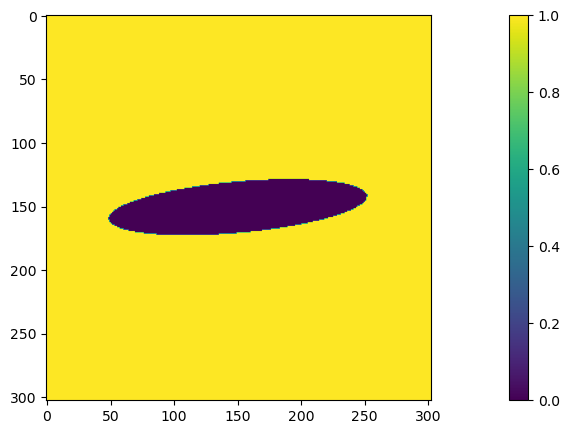

In [14]:
# Showing masked image
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(~(mask_2.astype(bool)))
plt.colorbar();

## Make the mask (318, 318, 3), where the third dimension represents the same 2D mask array duplicated three times

In [15]:
mask = np.dstack([mask_2.astype(bool), mask_2.astype(bool), mask_2.astype(bool)])
mask.shape

(303, 303, 3)

In [16]:
mimage_data = ma.array(image_data, mask=~mask)
mimage_data.shape

(303, 303, 3)

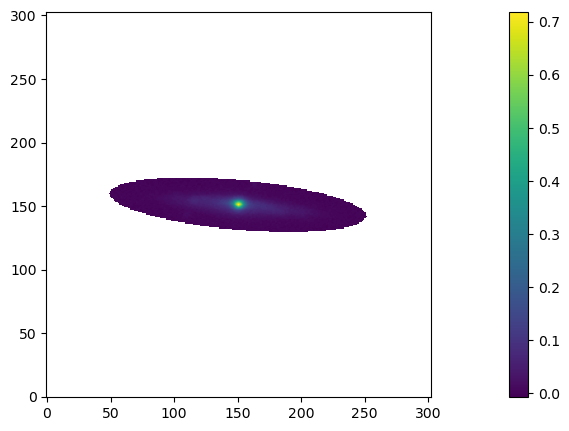

In [17]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.imshow(mimage_data[:,:,0], origin='lower')
plt.colorbar();

In [18]:
g_unmasked = mimage_data[:,:,0].compressed()
r_unmasked = mimage_data[:,:,1].compressed()
z_unmasked = mimage_data[:,:,2].compressed()

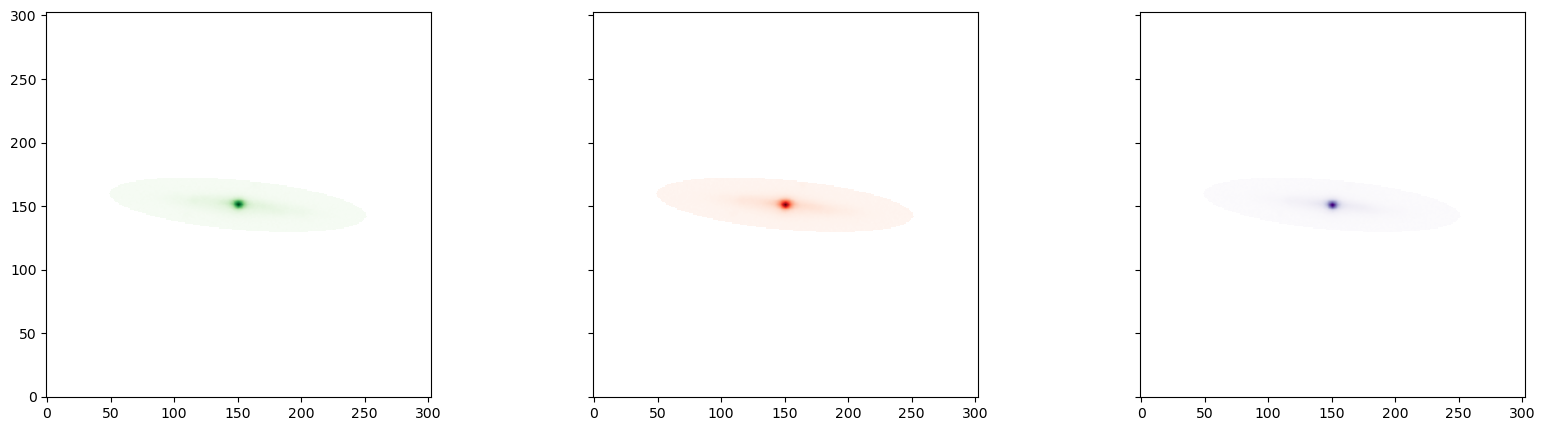

In [19]:
## plt.figure()
ax1=plt.subplot(131)
plt.imshow(mimage_data[:,:,0], origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mimage_data[:,:,1], origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mimage_data[:,:,2], origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

## Mask each color separately

In [20]:
mg_image = ma.array(image_data[:,:,0], mask=~mask_2.astype(bool))
mr_image = ma.array(image_data[:,:,1], mask=~mask_2.astype(bool))
mz_image = ma.array(image_data[:,:,2], mask=~mask_2.astype(bool))

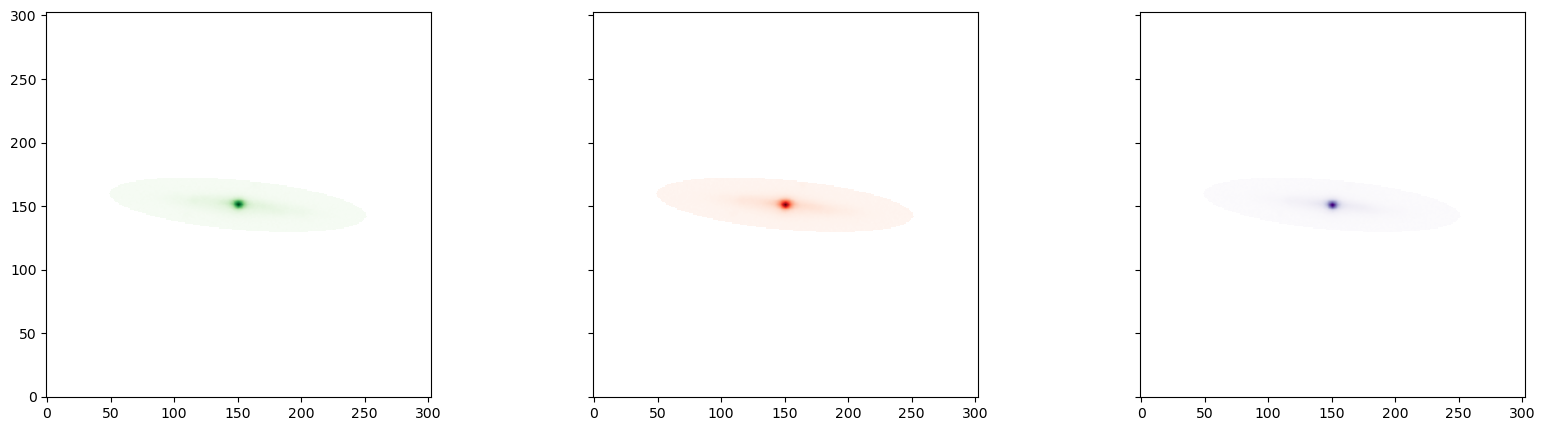

In [21]:
plt.figure()
ax1=plt.subplot(131)
plt.imshow(mg_image, origin='lower', cmap='Greens')
plt.subplot(132, sharey=ax1)
plt.imshow(mr_image, origin='lower', cmap='Reds')
plt.tick_params('y', labelleft=False)
plt.subplot(133, sharey=ax1)
plt.imshow(mz_image, origin='lower', cmap='Purples')
plt.tick_params('y', labelleft=False);

## Gini Coefficient Calculation for each band

In [22]:
g = mg_image.compressed()
r = mr_image.compressed()
z = mz_image.compressed()

In [23]:
g_filter = g[g > 0]
r_filter = r[r > 0]
z_filter = z[z > 0]

In [30]:
n = len(g_filter)    
sorted_x = np.sort(g_filter)    
numerator1 = np.sum([((2*i - n - 1) * sorted_x[i-1]) for i in range(1, n+1)])
denominator1 =  np.mean(sorted_x) * n * (n-1)
gini_g = (numerator1) / (denominator1)                
print('gini_green =', gini_g)

gini_green = 0.7102455524548937


In [31]:
n = len(r_filter)    
sorted_x = np.sort(r_filter)    
numerator2 = np.sum([((2*i - n - 1) * sorted_x[i-1]) for i in range(1, n+1)])
denominator2 =  np.mean(sorted_x) * n * (n-1)
gini_r = (numerator2) / (denominator2)                    
print('gini_r =', gini_r)

gini_r = 0.7451875941565521


In [32]:
n = len(z_filter)    
sorted_x = np.sort(z_filter)    
numerator3 = np.sum([((2*i - n - 1) * sorted_x[i-1]) for i in range(1, n+1)])
denominator3 =  np.mean(sorted_x) * n * (n-1)
gini_z = (numerator3) / (denominator3)                   
print('gini_z =', gini_z)

gini_z = 0.7507873649960575
